# KH-9 PC Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import hipp
import history
import usgsxplore

In [3]:
# Parameters

PROJECT_DIRECTORY = "/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25"
RAW_IMAGES = os.path.join(PROJECT_DIRECTORY, "raw_images")
JOINED_IMAGES = os.path.join(PROJECT_DIRECTORY, "joined_images")
PREPROCESSED_IMAGES = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")
CROPPING_BORDERS_FILE = os.path.join(PROJECT_DIRECTORY, "cropping_borders.csv")

QUICKVIEW_FACTOR = 0.05

# for the downloading via USGS
username = os.getenv("USGS_USERNAME") or input("Enter your USGS username: ")
token = os.getenv("USGS_TOKEN") or input("Enter your USGS token: ")

## Step 1 : Download raw images

To download the raw images we will use [`usgsxplore`](https://github.com/adehecq/usgs_explorer) which is an python interface to the [USGS M2M API](https://m2m.cr.usgs.gov/) to search and download data available from the [Earth Explorer](https://earthexplorer.usgs.gov/) platform.
We will download 6 images and each image is separated in 10 parts : `_a`, `_b`, `_c`, ...
The total downloading size is 53 Go, so it can take a will. Further more, the stagging links from the [USGS M2M API](https://m2m.cr.usgs.gov/) can take some time.
The downloading include already the extracting and the optimizing of tif files.

In [5]:
entity_ids = history.dataquery.get_casa_grande_kh9pc_ids()
entity_ids

['D3C1214-100097A013',
 'D3C1214-100097A014',
 'D3C1214-100097A015',
 'D3C1214-100097F012',
 'D3C1214-100097F013',
 'D3C1214-100097F014']

In [6]:
api = usgsxplore.API(username, token)
api.download("declassiii", entity_ids, output_dir=RAW_IMAGES)
api.logout()

history.dataquery.download_casa_grande_kh9pc_metadata(PROJECT_DIRECTORY)

if not os.path.exists(os.path.join(RAW_IMAGES, "quickviews")):
    hipp.tools.generate_quickviews(RAW_IMAGES, QUICKVIEW_FACTOR, max_workers=8)


## Step 2 : Joining Images

The first step of the preprocessing pipeline is to **join multiple image tiles** into a single, continuous image. This process is necessary because **KH9 PC images are typically split into 10 separate parts**, each approximately **1 GB in size**, due to their large original resolution.

However, **joining these image parts is not straightforward**, primarily because there is a **slight overlap between adjacent tiles**. 


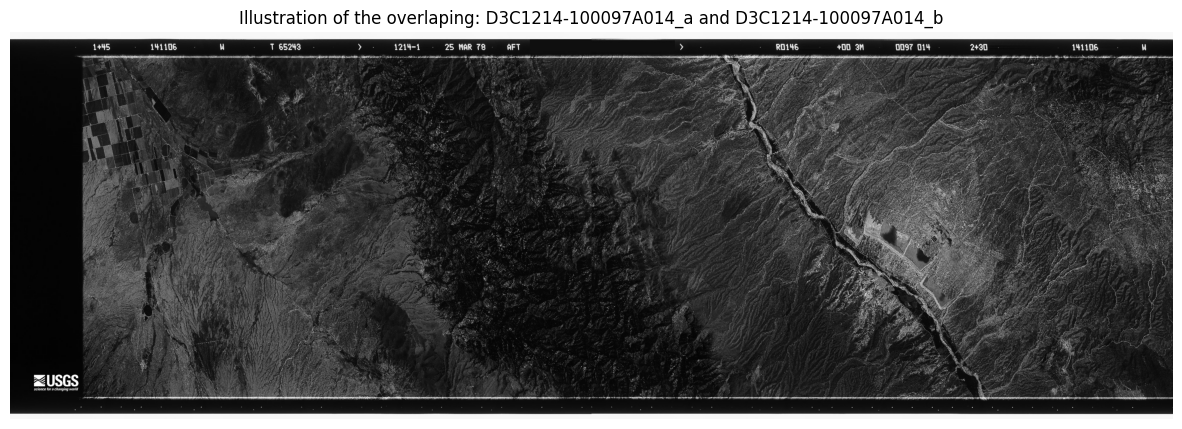

In [9]:
entity_id = "D3C1214-100097A014"
quickviews_dir = os.path.join(RAW_IMAGES, "quickviews")

image_a_path = os.path.join(quickviews_dir, f"{entity_id}_a.jpg")
image_b_path = os.path.join(quickviews_dir, f"{entity_id}_b.jpg")

image_a = cv2.imread(image_a_path)
image_b = cv2.imread(image_b_path)

concat_image = cv2.hconcat([image_a, image_b])

plt.figure(figsize=(15, 8))
plt.imshow(concat_image, cmap="gray")
plt.axis("off")
plt.title(f"Illustration of the overlaping: {entity_id}_a and {entity_id}_b")
plt.show()

To accurately reconstruct the full image, we need to perform the following steps:

1. **Detect keypoints (interest points)** along the **right border** of the first image part.
2. Detect corresponding keypoints along the **left border** of the next image part.
3. **Match these keypoints** using a feature-matching algorithm to find candidate correspondences.
4. Use **RANSAC (Random Sample Consensus)** to filter out mismatched or erroneous correspondences (i.e., outliers).
5. Estimate a **relative geometric transformation** (typically a translation or affine transform) to correctly align the second image with the first.
6. Apply this transformation and **merge the two parts** into a larger composite image.

This process is repeated sequentially for all image parts, progressively building up the full image mosaic.

To perform that the function `join_images` will use the [`image_mosaic`](https://stereopipeline.readthedocs.io/en/latest/tools/image_mosaic.html) program from Ames Stereo Pipeline

In [11]:
# IMPORTANT : this bloc of code can take really long time, in my machine it take's around 40 min per images
history.preproc_kh9pc.join_images(RAW_IMAGES, JOINED_IMAGES, threads=5)

hipp.tools.generate_quickviews(JOINED_IMAGES, factor=QUICKVIEW_FACTOR, max_workers=8)

Skipping D3C1214-100097F013: output already exists.
Skipping D3C1214-100097A013: output already exists.
Skipping D3C1214-100097F012: output already exists.
Skipping D3C1214-100097F014: output already exists.
Mosaicking D3C1214-100097A015 with 12 tiles...
image_mosaic /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D3C1214-100097A015_a.tif /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D3C1214-100097A015_b.tif /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D3C1214-100097A015_c.tif /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D3C1214-100097A015_d.tif /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D3C1214-100097A015_e.tif /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D3C1214-100097A015_f.tif /home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/raw_images/D

Generating quickviews: 100%|██████████| 6/6 [01:03<00:00, 10.56s/image]


In [11]:
history.preproc_kh9pc.clicking_on_corner(JOINED_IMAGES, CROPPING_BORDERS_FILE)

In [9]:
history.preproc_kh9pc.crop_images(JOINED_IMAGES, CROPPING_BORDERS_FILE, PREPROCESSED_IMAGES)
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES, QUICKVIEW_FACTOR, max_workers=8)

[D3C1214-100097A013] Skipped: output already exists at '/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/preprocessed_images/D3C1214-100097A013.tif'
[D3C1214-100097A015] Skipped: output already exists at '/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/preprocessed_images/D3C1214-100097A015.tif'
[D3C1214-100097F014] Skipped: output already exists at '/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/preprocessed_images/D3C1214-100097F014.tif'
[D3C1214-100097F012] Skipped: output already exists at '/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/preprocessed_images/D3C1214-100097F012.tif'
[D3C1214-100097A014] Skipped: output already exists at '/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/preprocessed_images/D3C1214-100097A014.tif'
[D3C1214-100097F013] Skipped: output already exists at '/home/godinlu/Documents/history-dataset-v2/casa_grande/kh9pc/1978_03_25/preprocessed

Generating quickviews: 100%|██████████| 6/6 [00:11<00:00,  1.95s/image]
